# Read in data and set up plotting

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import ast
from scipy.spatial.distance import pdist,cdist
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt 
from numpy.random import permutation
import random 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools
import networkx as nx

def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()


def clean_condition_col(x):
    if x == "f_l":
        return "LowExposure\nLabeled"
    elif x == "f_u":
        return "LowExposure\nUnlabeled"
    elif x == "m_l":
        return "HiExposure\nLabeled"
    elif x == "m_u":
        return "HiExposure\nUnlabeled"
    elif x == "h":
        return "HumanControl"
    
df = pd.read_csv("../../data/experiment_data/data_clean_with_elab.csv")
df['init_array'] = df['init_array'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['clean_condition'] = df['condition'].apply(lambda x: clean_condition_col(x))
df.head() 

/Users/jashkina/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Unnamed: 0,response_id,participant_id,response_text,response_date,condition,condition_order,item,response_chain,init_array,...,idea6_txt,idea_minus_excluded6_txt,source,trial_no,trial_no_excluded,elab_ibf,elab_ipf,elab_not_sw,elab_n_tokens,clean_condition
0,0,da90af9c-e2e7-4309-9ff0-3f7067b7a6a7,0b53acd4-eef9-4cc9-89b4-d041c93a8474,sock dispenser,2023-07-14 01:11:16,h,0,shoe,3,"[f580f114-af7e-4d8e-8b0f-b8721ad441de, d8f156b...",...,Knee pads,Knee pads,Creative Mornings newsletter,13,12.0,2.651837,7.288467,2,2,HumanControl
1,1,1fdfaed9-f4db-435f-940d-470b12cfcaee,c077bfaf-e624-4110-8212-dda6b23dc188,shoe as something used to play a game,2023-07-14 02:01:00,h,0,shoe,3,"[85eae1c0-b64f-406d-aae1-ce5f5db8a6c3, f580f11...",...,"a house for a little old lady and her wee, tin...","a house for a little old lady and her wee, tin...",Creative Mornings newsletter,16,15.0,2.918359,9.136040,3,8,HumanControl
2,2,5b3c4540-464f-4266-86e0-94e4d40bee18,27419286-9691-47b0-aa2c-d78eecdb5794,Attach shoe to wall and use the laces to hang ...,2023-07-14 01:13:22,h,0,shoe,3,"[dd3c538d-f5a4-4b53-b5f7-d37d679e8053, d8f156b...",...,Knee pads,Knee pads,Creative Mornings newsletter,14,13.0,6.161908,17.942674,7,12,HumanControl
3,3,4f4f3050-e47b-440f-8a46-64ed6ff76d42,4d682a85-5150-4231-829d-0c8bc9a0267b,home for plants,2023-07-14 02:44:52,h,0,shoe,3,"[5b3c4540-464f-4266-86e0-94e4d40bee18, 2f4bf01...",...,shoe as something used to play a game,shoe as something used to play a game,Creative Mornings newsletter,18,17.0,1.149419,3.735428,2,3,HumanControl
4,4,64c1edb9-b90d-4d62-ada3-642dc9bb1551,79a6c59e-9eb8-4602-ac28-330a88463401,Place it near a backyard door and use it to ho...,2023-07-14 03:10:38,h,0,shoe,3,"[ffdbf261-99a2-4e8e-9ab7-9bfe41c171f2, 4f4f305...",...,Attach shoe to wall and use the laces to hang ...,Attach shoe to wall and use the laces to hang ...,Creative Mornings newsletter,19,18.0,6.185689,18.360093,9,14,HumanControl


# Get embeding of all ideas

The goal is to get a hash map `idea2vec` where key is text and value is sbert vector

In [2]:
model = SentenceTransformer('all-MiniLM-L12-v2')
example_cols = [x for x in df.columns if "_txt" in x and "excluded" not in x]

# Gather all ideas
df['init_array_list'] = df[example_cols].values.tolist()
all_ideas = []
all_ideas.extend(df['response_text'])
for x in example_cols:
    all_ideas.extend(df[x].to_list())
all_ideas = list(set(all_ideas))

# Get embeddings and create idea2vec mapping
embeddings = model.encode(all_ideas)
idea2vec = dict(zip(all_ideas, embeddings))

## Inferential Statistics



- We will first do a Kruskal Wallis test to see if the `dv` differs by `condition`. This is a non-parametric equivalent to ANOVA. If the dv differs by condition, we follow up with...

- Permutation tests on the difference in means with an fdr correction for multiple comparisons. I chose this analysis strategy because this stuff is weirdly distributed

- Do I do median or means actually?

In [3]:
from numpy.random import permutation
import random 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools
import pandas as pd

def process_metrics(mydf, plot_type='box'):
    """
    Process the metrics for a dataframe. This handles all the analysis. When fed a dataframe it looks for columns containing
    `sim` or `dist` and analyzes them. 
    
    Foreach distance or similarity dv:
    
    1. Conduct a Kurskal Wallis test (akin to non-parametric ANOVA) to see if `dv` differs by condition. 
    2. Plot the distribution of `dv` by condition
    3. Conduct pairwise permutation tests (testing for a difference in means) and apply an FDR adjustment to p-values
    """
    dist_metrics = [x for x in mydf.columns if "sim" in x or "dist" in x]
    print(dist_metrics)
    for dv in dist_metrics:
        plt.show()
        kruskal_wallis(mydf, "clean_condition", dv)
        display(pairwise_permutation(mydf, "clean_condition", dv))
        plot_distributions(mydf, "clean_condition", dv, plot_type)
        
def plot_distributions(tdf, group_col, data_col, plot_type):
    # We have many graphs, need to have each condition mapped to consistent color
    # Let's make it so unlabeled is a lighter shade of labeled 
    
    if data_col.startswith("ai"):
        tdf = tdf.query("condition != 'h'")
    else:
        pass
    
    if plot_type == "box":
        graph_func = sns.boxplot
    elif plot_type == "swarm":
        graph_func = sns.swarmplot
    elif plot_type == "strip":
        graph_func = sns.stripplot
    elif plot_type == 'bar':
        graph_func = sns.barplot
    elif plot_type == "line":
        graph_func = sns.lineplot
    elif plot_type == "point":
        graph_func = sns.pointplot
    else:
        raise ValueError(f"Unknown plot_type: {plot_type}")

    color_dict = {'LowExposure\nLabeled':'#388659', 
              'LowExposure\nUnlabeled':'#7EC99D',
              'HumanControl':'#D41876',
              'HiExposure\nLabeled':'#826AED', 
              'HiExposure\nUnlabeled':'#D1C8F9',   
             }
    order = tdf.groupby(group_col)[data_col].mean().sort_values().index
    plt.figure(figsize=(14,8))
    graph_func(data=tdf, x=group_col, y=data_col, order=order, palette=color_dict, errorbar=('ci', 95))
    plt.title(f"{data_col} by condition")
    plt.show()


def kruskal_wallis(tdf, group_col, data_col):
    """Kurskal Wallis test for non-parametric group differences"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    H, p = stats.kruskal(*[group[data_col].values for name, group in tdf.groupby(group_col)])
    if p < 0.05:
        print(f"We conducted a Kruskal Wallis test and found {data_col} differed by {group_col}, H={np.round(H, 2)}, p={np.round(p)}")
    return H, p

def pairwise_permutation(tdf, group_col, data_col, num_permutations=10000):
    """Concducts pairwise permutation tests with FDR correction"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    groups = tdf[group_col].unique()
    group_pairs = list(itertools.combinations(groups, 2))
    results = []

    for group1, group2 in group_pairs:
        group1_data = tdf[tdf[group_col] == group1][data_col]
        group2_data = tdf[tdf[group_col] == group2][data_col]
        
        # Perform permutation test
        p = perm_test(group1_data, group2_data, num_permutations)
        # Calculate the difference of medians
        mean_diff = np.mean(group1_data) - np.mean(group2_data)
        pooled_sd = sqrt((group1_data.std() ** 2 + group2_data.std() ** 2) / 2)
        ef_size = mean_diff / pooled_sd
        results.append([group1, group2, mean_diff,ef_size, p])

    results_df = pd.DataFrame(results, columns=['group1', 'group2', 'Diff in Means', "Cohen's d",'p'])
    reject, pvals_corrected, _, _ = multipletests(results_df['p'], method='fdr_bh')
    results_df['p_adj'] = pvals_corrected
    results_df['Reject Null'] = results_df['p_adj'].apply(lambda x: 'YES' if x < 0.05 else 'NO')
    return results_df

def perm_test(x, y, num_permutations):
    """Conducts a permutation test, returns p-value"""
    np.random.seed(416)
    random.seed(416)
    n = len(x)
    diff = np.abs(np.mean(x) - np.mean(y))
    combined = np.concatenate((x, y))
    count = 0
    for i in range(num_permutations):
        perm = permutation(combined)
        pcurrent = perm[:n]
        pnew = perm[n:]
        diffperm = np.abs(np.mean(pcurrent) - np.mean(pnew))
        if diffperm > diff:
            count += 1
    return count / num_permutations

# Local Diversity

Here, we look at the diversity of idea sets on a `local` level -- at the level of each trial. 

## Compute local diversity metrics

['cent_dist', 'mean_dist', 'min_dist', 'max_dist', 'ai_max_sim', 'ai_max_dist', 'ai_mean_dist']
We conducted a Kruskal Wallis test and found cent_dist differed by clean_condition, H=70.53, p=0.0


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,-0.002226,-0.032345,0.5509,0.569100,NO
1,HumanControl,LowExposure\nUnlabeled,-0.004375,-0.063489,0.2428,0.346857,NO
2,HumanControl,HiExposure\nLabeled,-0.023797,-0.330177,0.0000,0.000000,YES
3,HumanControl,HiExposure\nUnlabeled,-0.021454,-0.288212,0.0000,0.000000,YES
4,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.002149,-0.032044,0.5542,0.569100,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,-0.021572,-0.306755,0.0000,0.000000,YES
6,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.019228,-0.264333,0.0000,0.000000,YES
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.019422,-0.275815,0.0000,0.000000,YES
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.017079,-0.234487,0.0000,0.000000,YES
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.002344,0.030903,0.5691,0.569100,NO


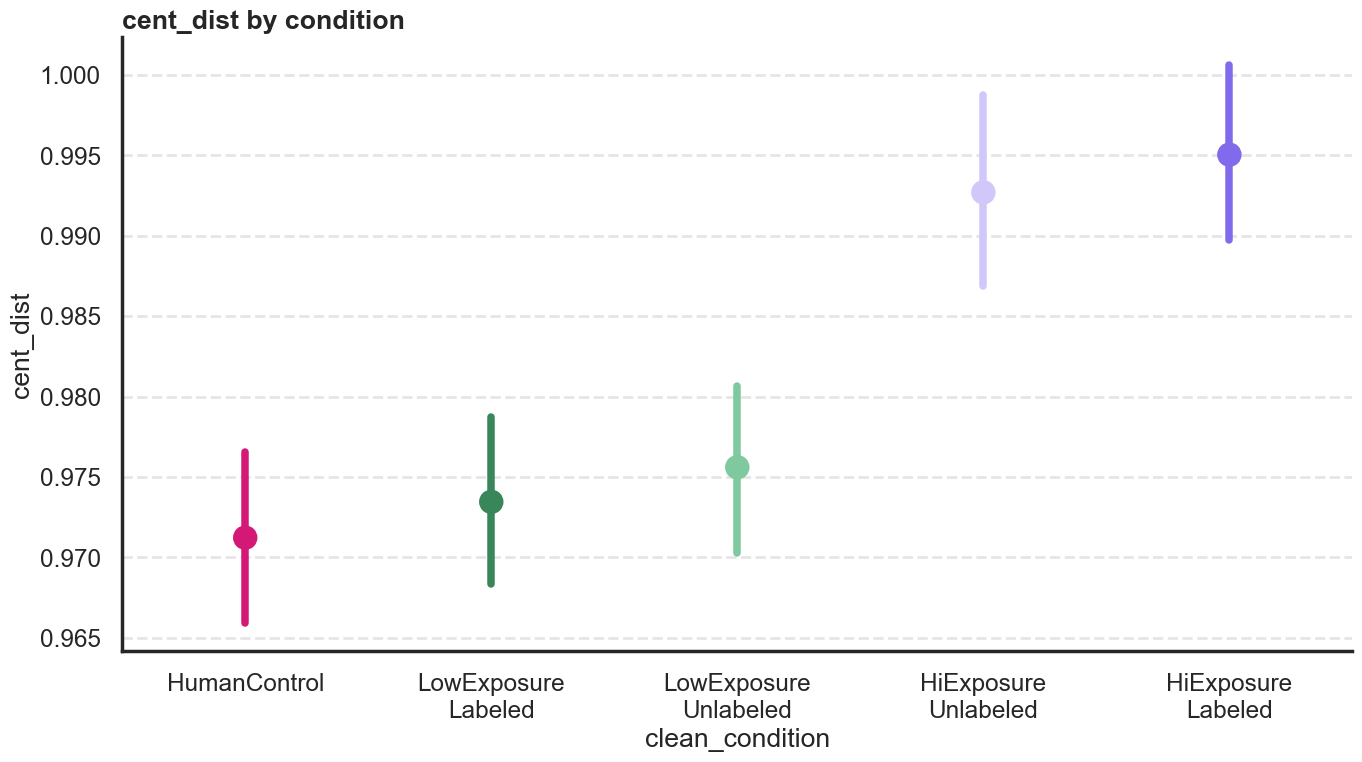

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,-0.000028,-0.000491,0.9925,0.992500,NO
1,HumanControl,LowExposure\nUnlabeled,-0.001033,-0.017841,0.7486,0.970111,NO
2,HumanControl,HiExposure\nLabeled,-0.002330,-0.038101,0.4803,0.970111,NO
3,HumanControl,HiExposure\nUnlabeled,0.000563,0.008894,0.8731,0.970111,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.001004,-0.018345,0.7424,0.970111,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,-0.002302,-0.039550,0.4725,0.970111,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.000592,0.009781,0.8572,0.970111,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.001297,-0.022213,0.6821,0.970111,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.001596,0.026297,0.6292,0.970111,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.002893,0.045336,0.4013,0.970111,NO


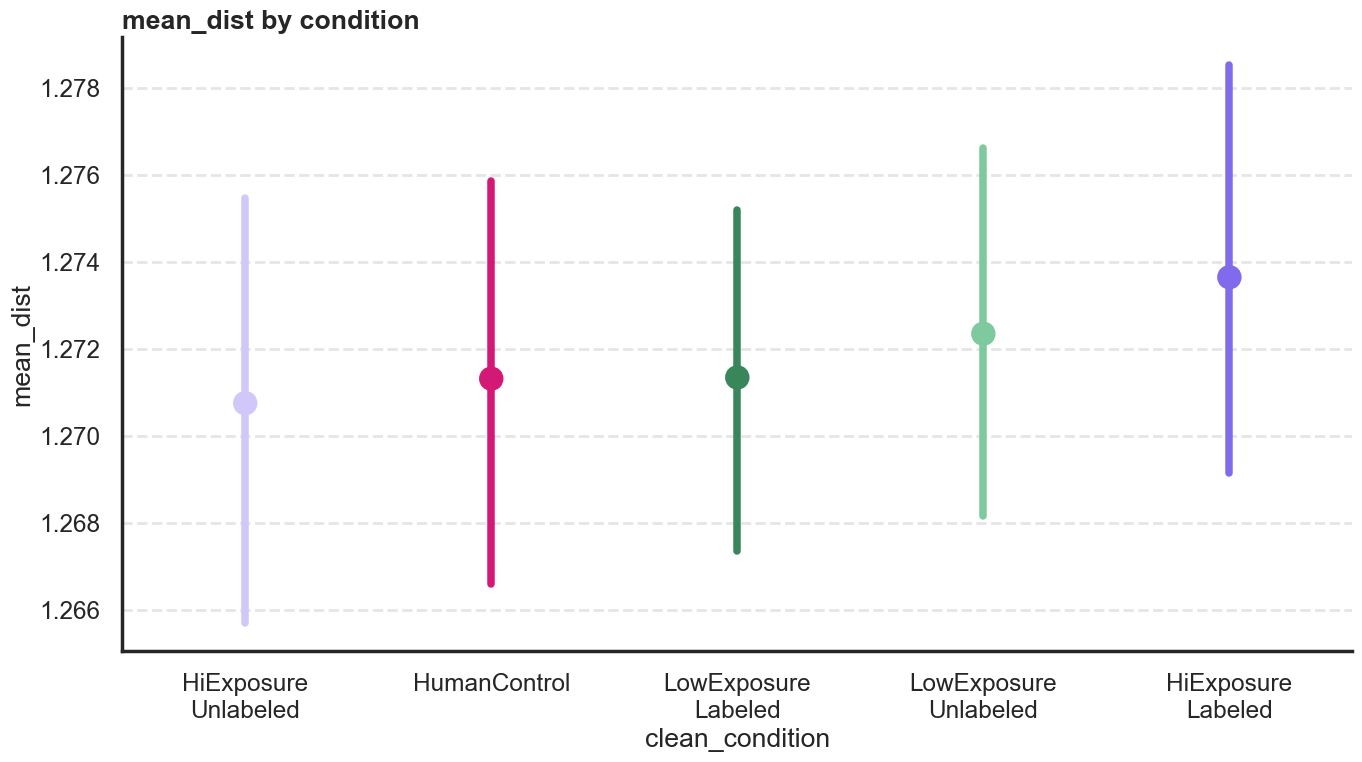

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,0.005826,0.056138,0.3011,0.657167,NO
1,HumanControl,LowExposure\nUnlabeled,0.003466,0.033857,0.5346,0.729750,NO
2,HumanControl,HiExposure\nLabeled,-0.004854,-0.046780,0.3871,0.657167,NO
3,HumanControl,HiExposure\nUnlabeled,0.000241,0.002182,0.9689,0.968900,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.002360,-0.022976,0.6730,0.747778,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,-0.010680,-0.102615,0.0589,0.589000,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.005585,-0.050388,0.3536,0.657167,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.008321,-0.081029,0.1322,0.657167,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.003225,-0.029446,0.5838,0.729750,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.005096,0.045978,0.3943,0.657167,NO


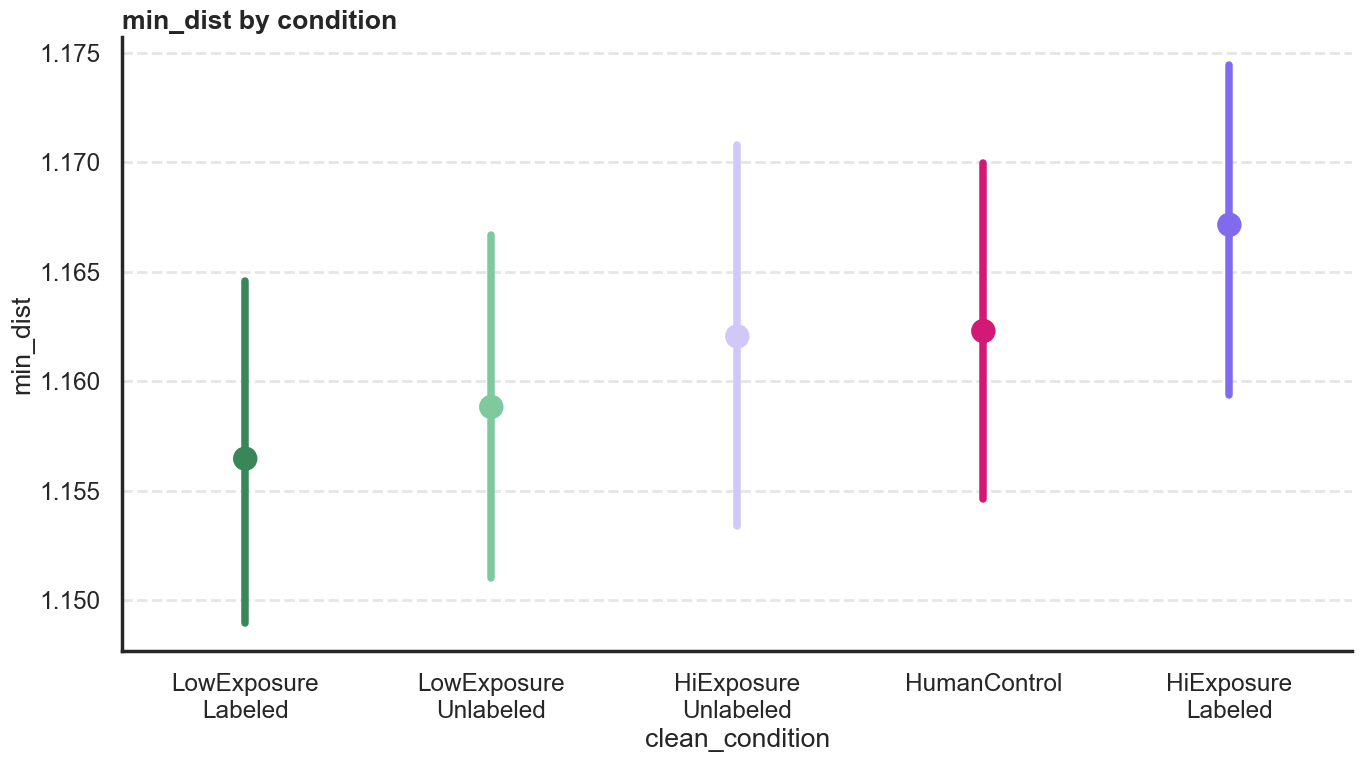

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,0.002238,0.048352,0.3700,0.528571,NO
1,HumanControl,LowExposure\nUnlabeled,0.001762,0.037156,0.4904,0.613000,NO
2,HumanControl,HiExposure\nLabeled,0.005641,0.114033,0.0361,0.215000,NO
3,HumanControl,HiExposure\nUnlabeled,0.005434,0.110824,0.0430,0.215000,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.000477,-0.010400,0.8540,0.941100,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.003403,0.070943,0.1919,0.347833,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.003195,0.067251,0.2087,0.347833,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,0.003880,0.079101,0.1398,0.347833,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.003672,0.075551,0.1594,0.347833,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.000208,-0.004106,0.9411,0.941100,NO


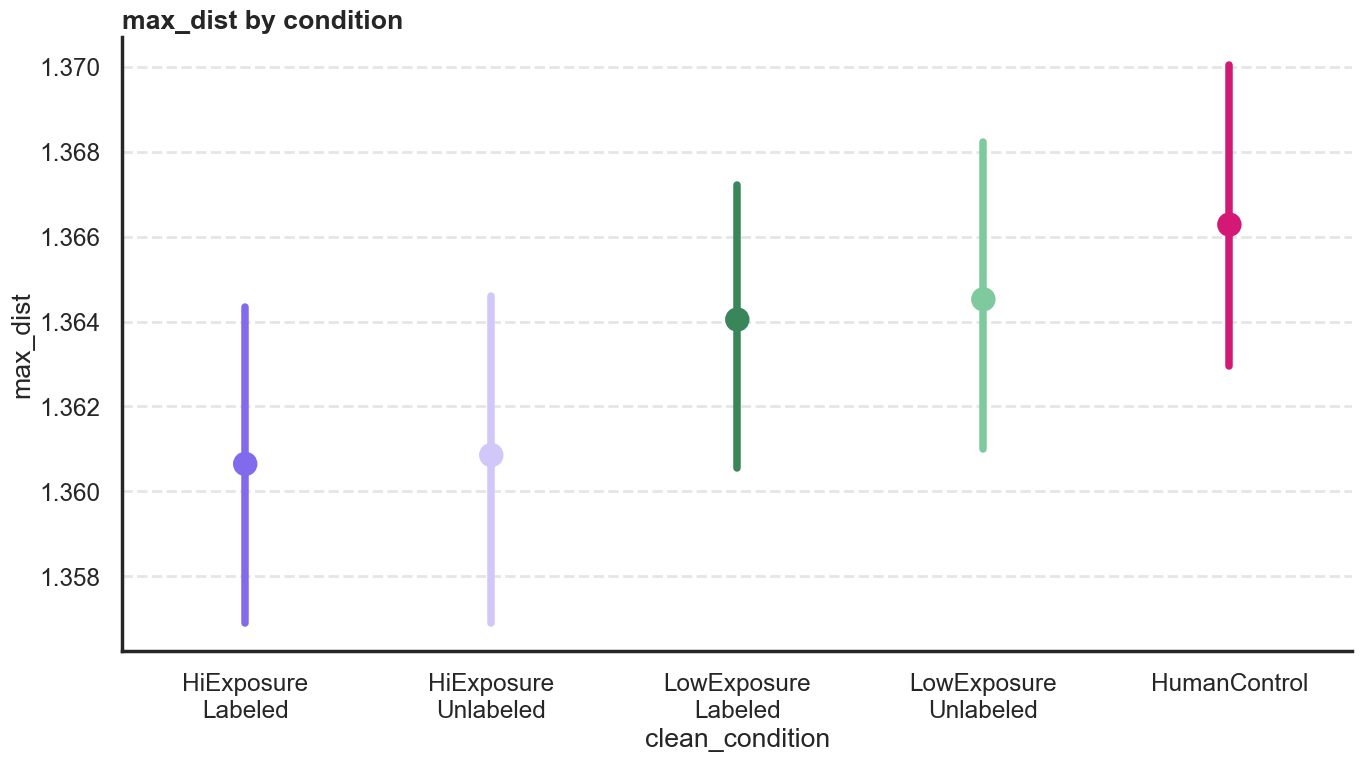

We conducted a Kruskal Wallis test and found ai_max_sim differed by clean_condition, H=100.86, p=0.0


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,LowExposure\nLabeled,LowExposure\nUnlabeled,0.007676,0.065843,0.2318,0.27816,NO
1,LowExposure\nLabeled,HiExposure\nLabeled,-0.038967,-0.331463,0.0000,0.00000,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.046100,-0.380029,0.0000,0.00000,YES
3,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.046643,-0.395538,0.0000,0.00000,YES
4,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.053775,-0.442027,0.0000,0.00000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.007132,-0.058175,0.2854,0.28540,NO


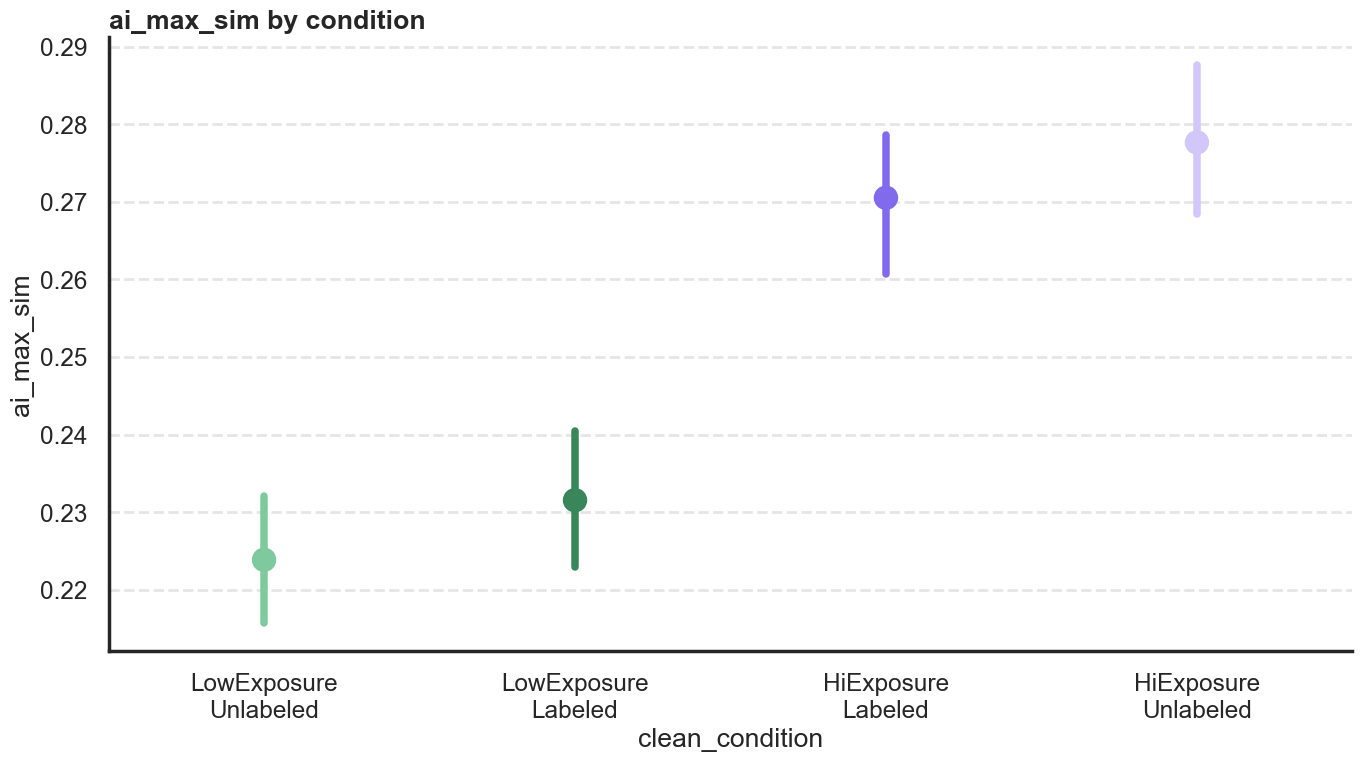

We conducted a Kruskal Wallis test and found ai_max_dist differed by clean_condition, H=100.66, p=0.0


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.006985,-0.095987,0.0770,0.0924,NO
1,LowExposure\nLabeled,HiExposure\nLabeled,-0.029521,-0.433471,0.0000,0.0000,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.028656,-0.412786,0.0000,0.0000,YES
3,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.022536,-0.328245,0.0000,0.0000,YES
4,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.021671,-0.309751,0.0000,0.0000,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.000865,0.013284,0.7964,0.7964,NO


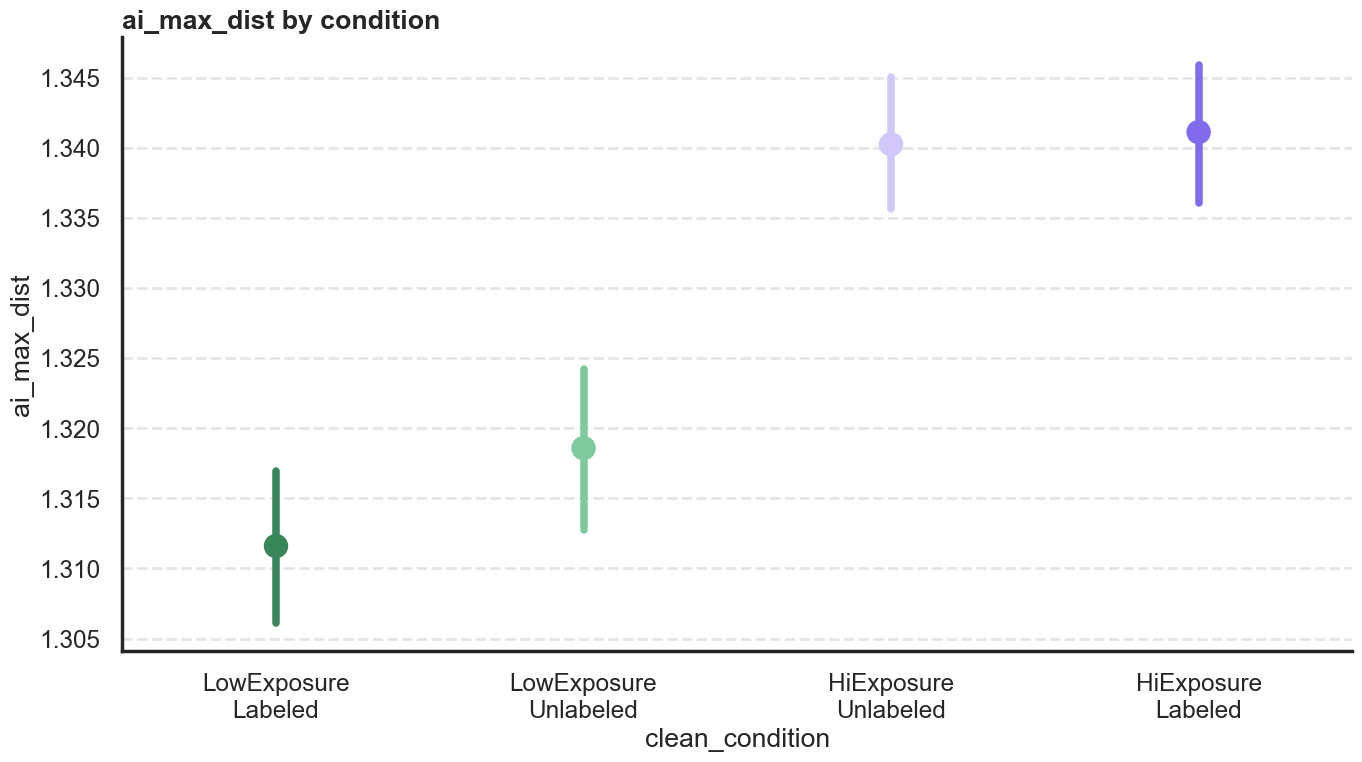

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.006615,-0.085181,0.1189,0.35670,NO
1,LowExposure\nLabeled,HiExposure\nLabeled,-0.002421,-0.032274,0.5512,0.55120,NO
2,LowExposure\nLabeled,HiExposure\nUnlabeled,0.002670,0.033695,0.5332,0.55120,NO
3,LowExposure\nUnlabeled,HiExposure\nLabeled,0.004194,0.055716,0.3029,0.45435,NO
4,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.009285,0.116814,0.0320,0.19200,NO
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.005090,0.066199,0.2194,0.43880,NO


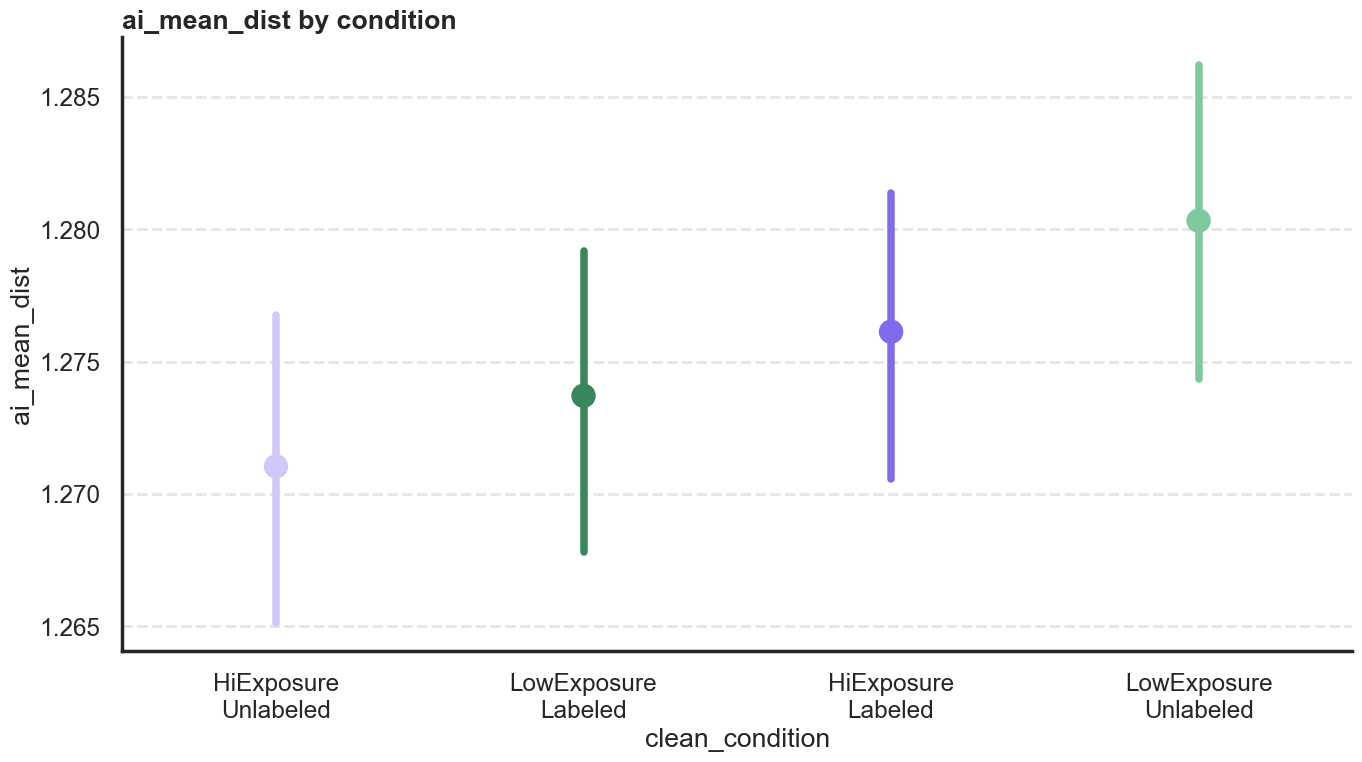

In [4]:
def local_semantic_measures(row, idea2vec):
    response_text = row['response_text']
    example_list = row['init_array_list']
    example_rids = row['init_array']

    ai_ideas = [example_list[i] for i in range(len(example_list)) if "ai" in example_rids[i].lower()]

    idea_vec = idea2vec[response_text]
    example_vecs = [idea2vec[example] for example in example_list]
    ai_example_vecs = [idea2vec[example] for example in ai_ideas]
    union_vecs = example_vecs + [idea_vec]

    distances_to_examples = cdist([idea_vec], example_vecs)
    
    # distance between idea_vec and centroid of example_vecs
    centroid = np.mean(example_vecs, axis=0)
    cent_dist = cdist([idea_vec], [centroid])

    # max similarity and max distance for ai_example_vecs
    if ai_example_vecs:
        ai_sim = np.max(cosine_similarity([idea_vec], ai_example_vecs))
        ai_dist = np.max(cdist([idea_vec], ai_example_vecs))
        ai_mean_dist = np.mean(cdist([idea_vec], ai_example_vecs))

    else:
        ai_sim = 0
        ai_dist = 0
        ai_mean_dist = 0

    return pd.Series({
        'cent_dist': cent_dist[0][0],
        'mean_dist':np.mean(distances_to_examples),
        'min_dist': np.min(distances_to_examples),
        'max_dist': np.max(distances_to_examples),
        'ai_max_sim': ai_sim,
        'ai_max_dist': ai_dist,
        'ai_mean_dist':ai_mean_dist
        
    })

df = df.query("exclude_from_analysis==0")
semantic_measures_df = df.apply(lambda row: local_semantic_measures(row, idea2vec), axis=1)
df = pd.concat([df, semantic_measures_df], axis=1)
df = df.loc[:,~df.columns.duplicated()]

process_metrics(df, plot_type='point')

# Aggregated condition level

The idea is to: 
1. Make an undirected graph from semantic similarities between ideas
2. Partition this graph 
3. Count partitions as a proxy for 'distinct ideas'

But I realized that doing this at the response chain level is too low since you can't really build a semantic map with 20 ideas. Doing this at the condition level is good but results are confounded by different items. Doing this at the condition X item level makes the most sense, but then you only have 25 observations. 

So I create partitions at the (condition, item) level but bootstrap to get more data, then permutation test on the bootstrapped data.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['num_com_dist']
We conducted a Kruskal Wallis test and found num_com_dist differed by clean_condition, H=170.74, p=0.0


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.157,-0.217992,0.0000,0.000000,YES
1,HiExposure\nLabeled,HumanControl,0.060,0.091618,0.0367,0.040778,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,-0.232,-0.355728,0.0000,0.000000,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,-0.248,-0.415129,0.0000,0.000000,YES
4,HiExposure\nUnlabeled,HumanControl,0.217,0.300220,0.0000,0.000000,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,-0.075,-0.104116,0.0179,0.022375,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,-0.091,-0.135587,0.0026,0.003714,YES
7,HumanControl,LowExposure\nLabeled,-0.292,-0.445769,0.0000,0.000000,YES
8,HumanControl,LowExposure\nUnlabeled,-0.308,-0.512881,0.0000,0.000000,YES
9,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.016,-0.026775,0.5303,0.530300,NO


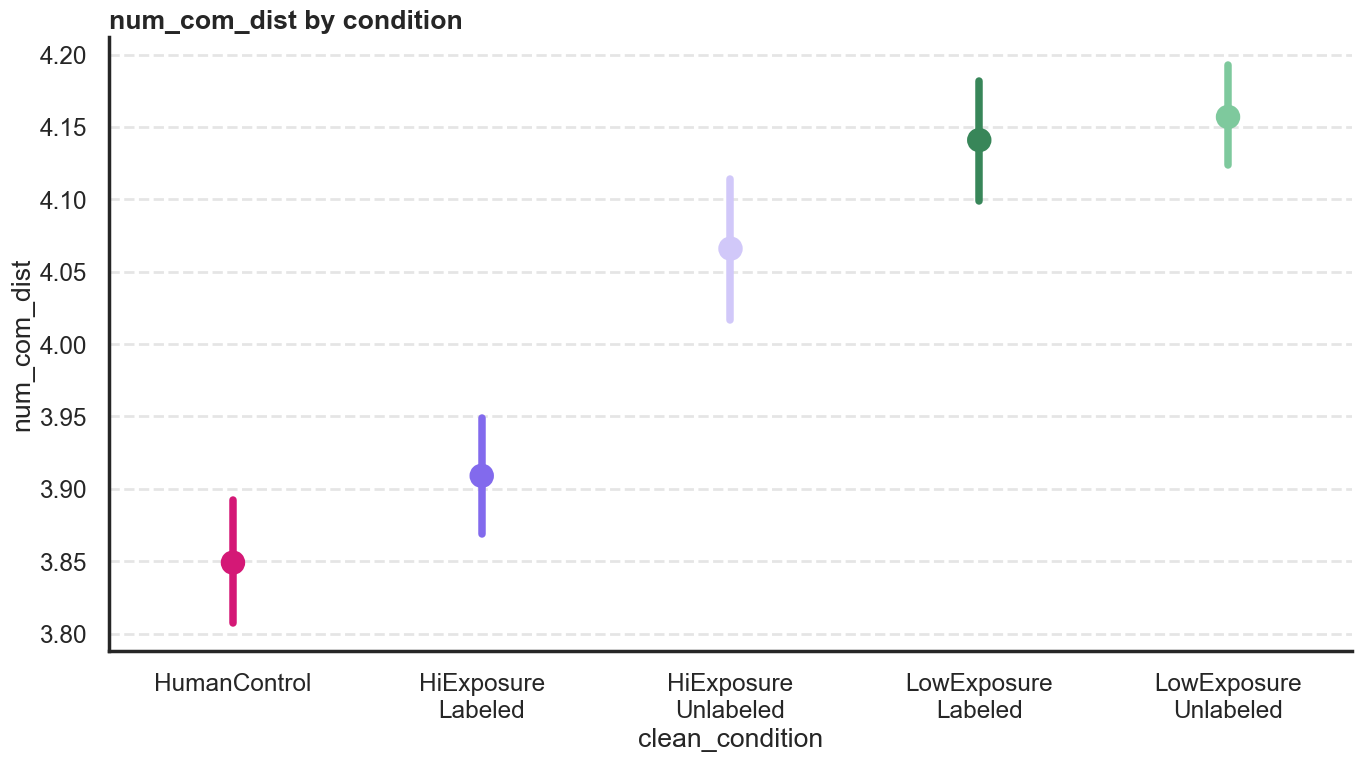

In [5]:
from joblib import Parallel, delayed
 
def get_communities(list_vecs, seed):
    sim_mat = cosine_similarity(list_vecs)
    G = nx.from_numpy_matrix(sim_mat)
    G.remove_edges_from(nx.selfloop_edges(G))
    partition = nx.community.louvain_communities(G, seed=seed, resolution=1)
    return len(partition)

def bootstrap_iteration(df, seed):
    df_sample = df.groupby(by=['clean_condition', 'item']).sample(frac=0.75, random_state=seed) 
    condition_ideas = df_sample.groupby(by=['clean_condition', 'condition', 'item'])['response_text'].apply(lambda x: list(x)).reset_index()
    condition_ideas['vectors'] = condition_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
    condition_ideas['num_com_dist'] = condition_ideas['vectors'].apply(lambda x: get_communities(x, seed))
    condition_ideas[['clean_condition', 'item', 'num_com_dist']]
    return condition_ideas

n_iterations = 200
bootstrap_results = Parallel(n_jobs=-1)(delayed(bootstrap_iteration)(df, i) for i in range(n_iterations))
bootstrap_results = pd.concat(bootstrap_results)
process_metrics(bootstrap_results, plot_type="point")

# Elab

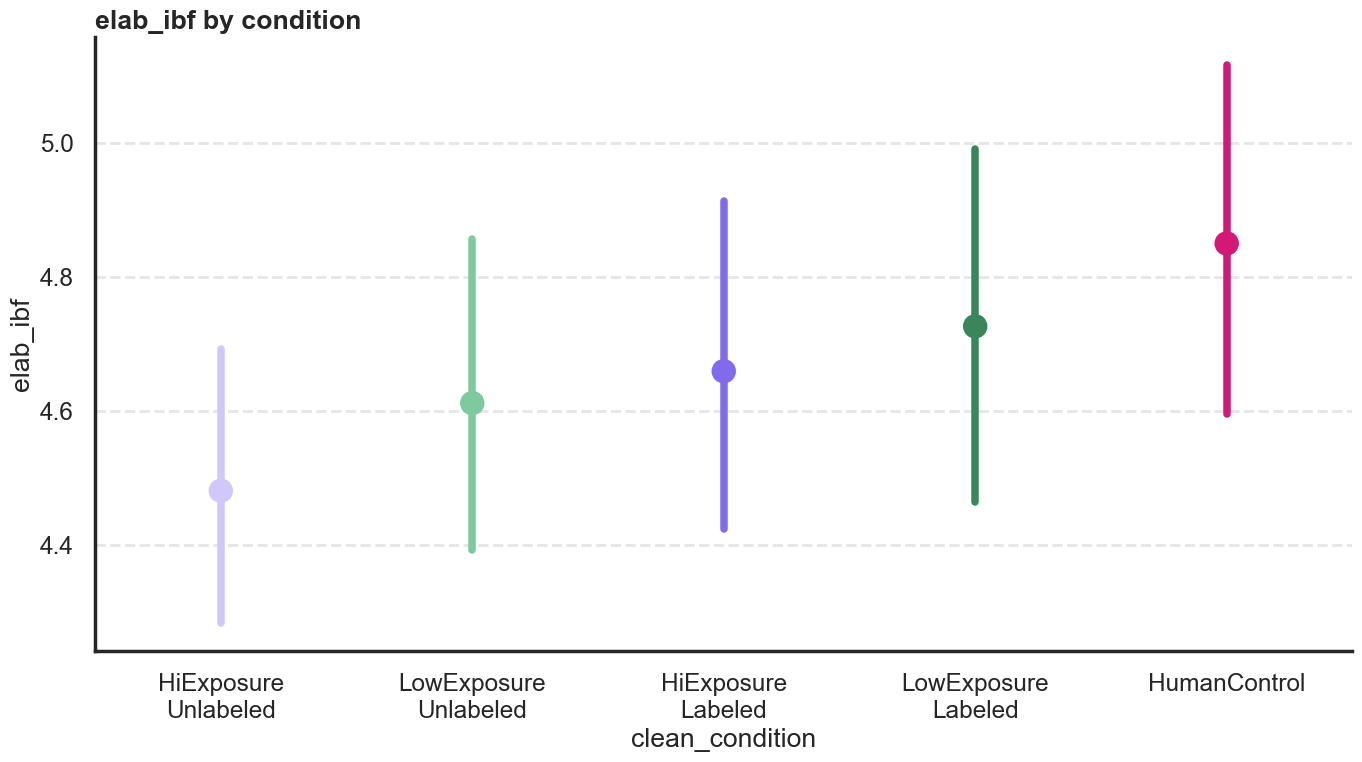

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,0.123789,0.034479,0.5267,0.658375,NO
1,HumanControl,LowExposure\nUnlabeled,0.238487,0.070922,0.1943,0.606800,NO
2,HumanControl,HiExposure\nLabeled,0.190886,0.054511,0.3034,0.606800,NO
3,HumanControl,HiExposure\nUnlabeled,0.369428,0.111077,0.0408,0.408000,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,0.114698,0.034878,0.5165,0.658375,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.067097,0.019558,0.7189,0.777700,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.245639,0.075561,0.1582,0.606800,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.047601,-0.014914,0.7777,0.777700,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.130941,0.043683,0.4151,0.658375,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.178542,0.056629,0.2891,0.606800,NO


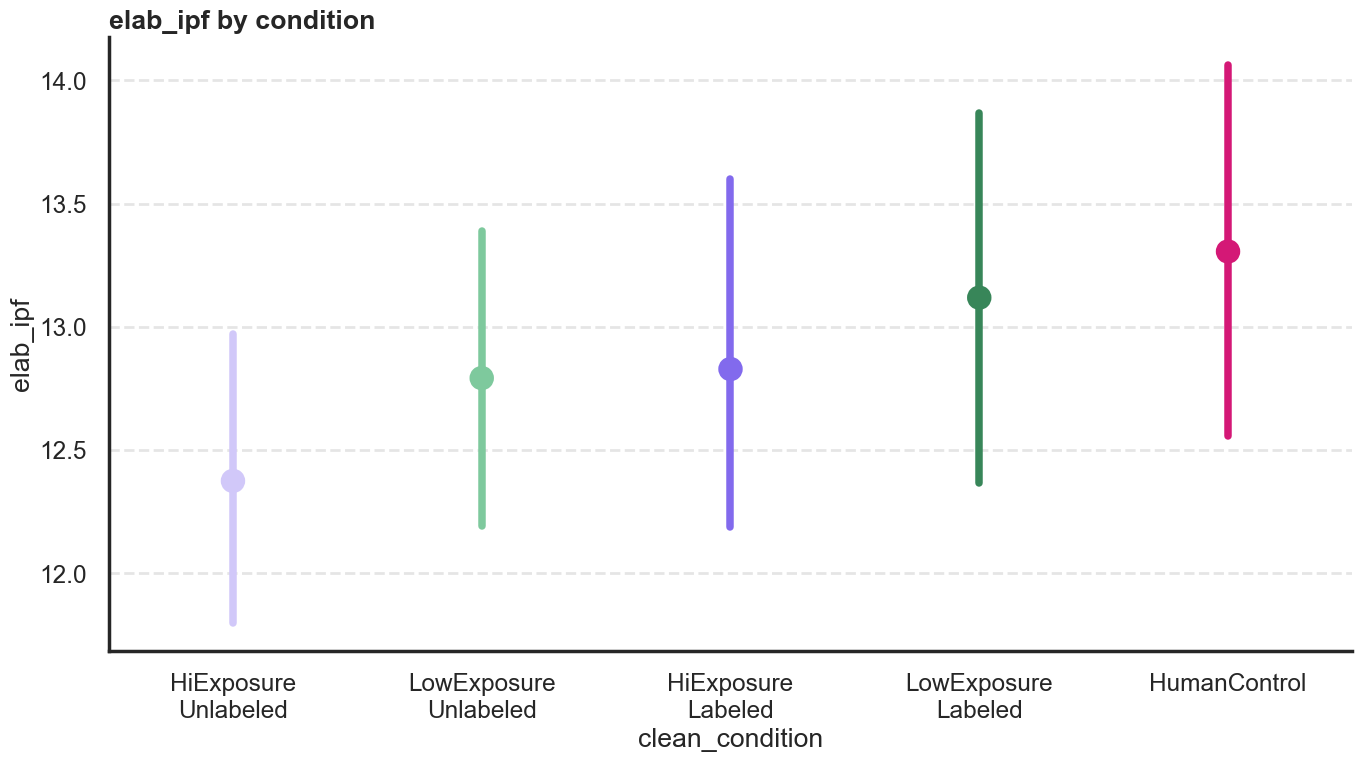

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,0.187337,0.018905,0.7247,0.805222,NO
1,HumanControl,LowExposure\nUnlabeled,0.513674,0.055635,0.3088,0.580333,NO
2,HumanControl,HiExposure\nLabeled,0.477107,0.049865,0.3482,0.580333,NO
3,HumanControl,HiExposure\nUnlabeled,0.930994,0.102693,0.0585,0.580333,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,0.326337,0.035928,0.5033,0.716250,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.289771,0.030750,0.5730,0.716250,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.743657,0.083433,0.1195,0.580333,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.036566,-0.004199,0.9354,0.935400,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.417320,0.051177,0.3381,0.580333,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.453887,0.053199,0.3207,0.580333,NO


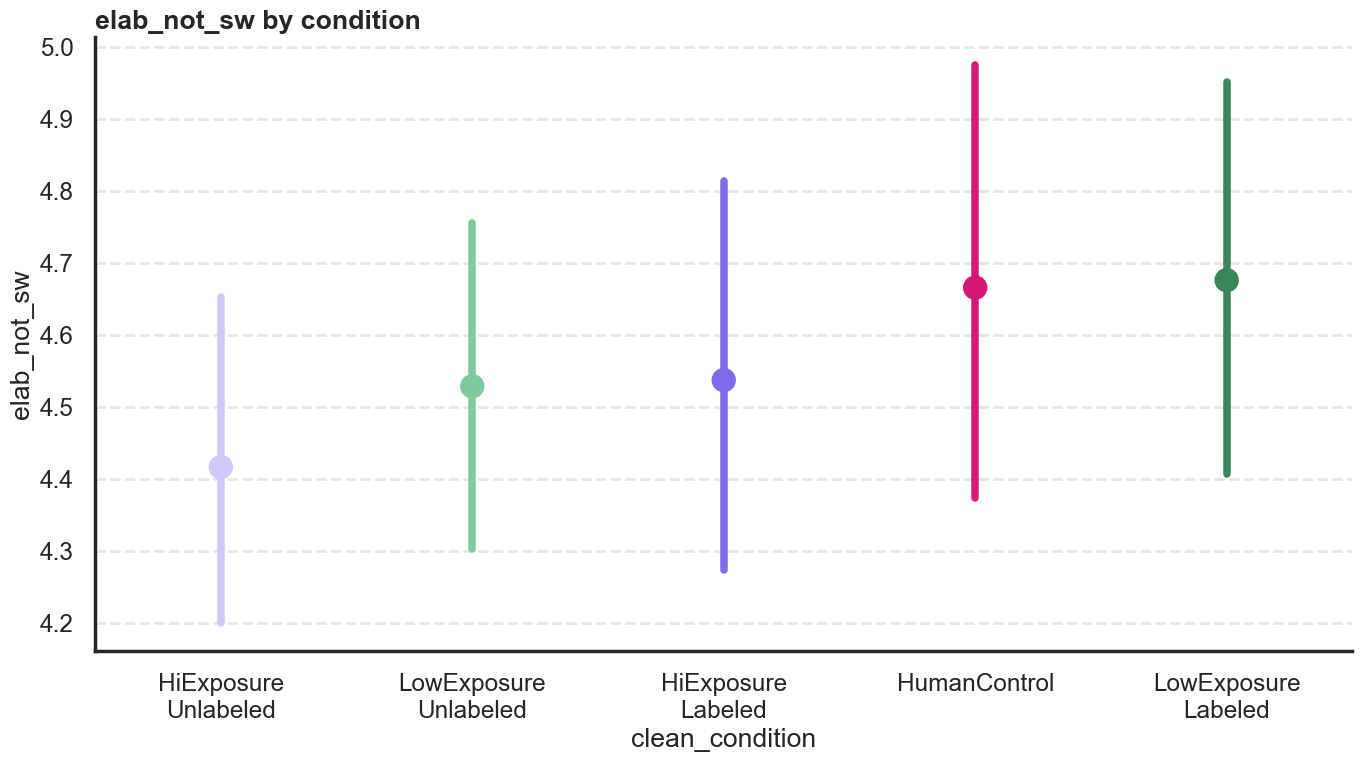

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,-0.010305,-0.002632,0.9590,0.961500,NO
1,HumanControl,LowExposure\nUnlabeled,0.137055,0.038080,0.4820,0.654375,NO
2,HumanControl,HiExposure\nLabeled,0.128463,0.034122,0.5235,0.654375,NO
3,HumanControl,HiExposure\nUnlabeled,0.249386,0.069466,0.2055,0.654375,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,0.147360,0.042788,0.4250,0.654375,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.138768,0.038368,0.4790,0.654375,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.259691,0.075613,0.1569,0.654375,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.008592,-0.002626,0.9615,0.961500,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.112332,0.036606,0.4870,0.654375,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.120924,0.037078,0.4887,0.654375,NO


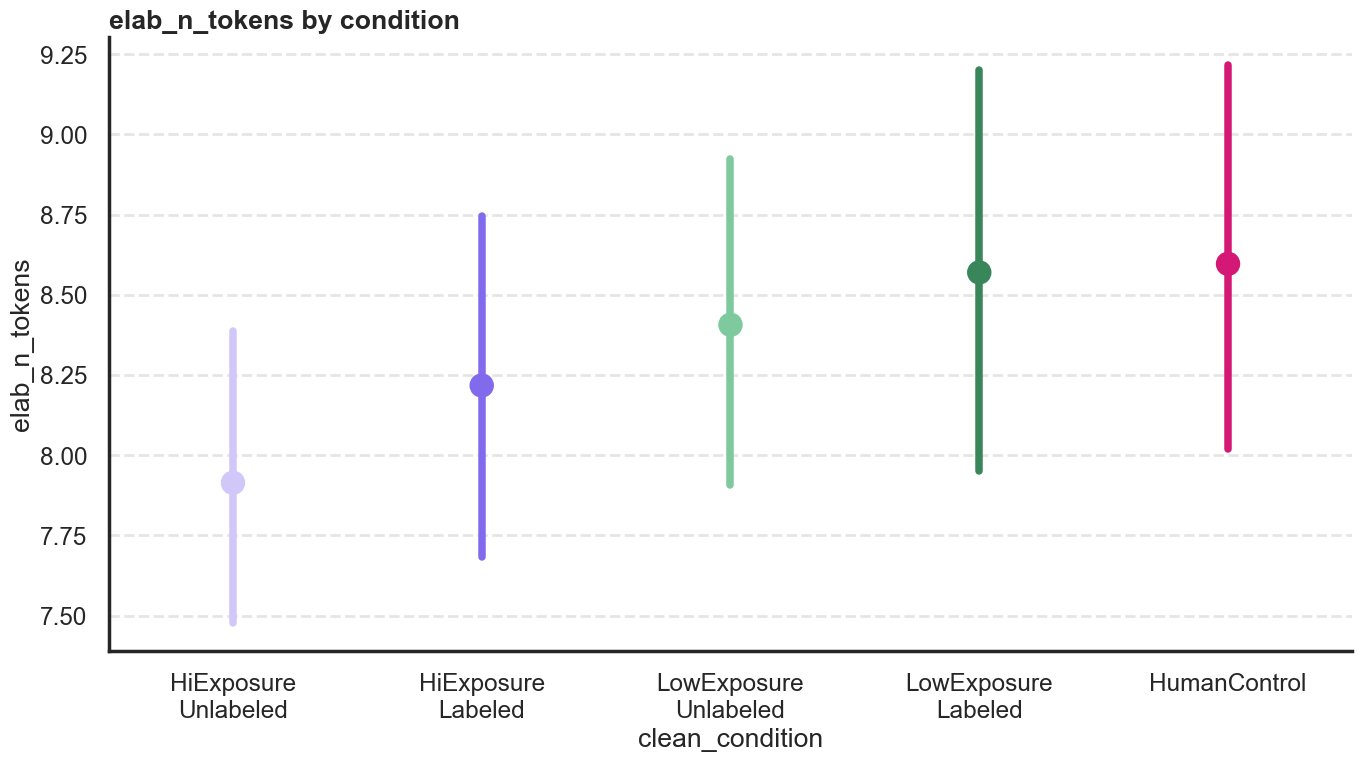

,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,0.026818,0.003285,0.9460,0.946000,NO
1,HumanControl,LowExposure\nUnlabeled,0.190019,0.025808,0.6326,0.753556,NO
2,HumanControl,HiExposure\nLabeled,0.379256,0.049549,0.3556,0.677667,NO
3,HumanControl,HiExposure\nUnlabeled,0.682655,0.093213,0.0858,0.505000,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,0.163201,0.021792,0.6782,0.753556,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.352438,0.045327,0.4019,0.677667,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.655836,0.088028,0.1010,0.505000,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,0.189237,0.027312,0.6091,0.753556,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.492635,0.075077,0.1655,0.551667,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.303399,0.044054,0.4066,0.677667,NO


In [6]:
elab_cols = [x for x in df.columns if "elab" in x]
for col in elab_cols:
    plot_distributions(df, "clean_condition", col, "point")
    display(pairwise_permutation(df, "clean_condition", col))